In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from keras.layers import Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [25]:
tweets = pd.read_csv('train.csv')
tweets['length']=tweets['text'].str.len()
tweets['keyword'] = tweets['keyword'].str.replace('%20', ' ')
tweets['keyword'].fillna('no keyword', inplace = True)
tweets = tweets.sample(frac=1,random_state=1)
tweets_test = pd.read_csv('test.csv')

In [26]:
tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [27]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [28]:
tweets['clean_text'] = tweets['clean_text'].apply(only_letters)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [29]:
#Tokenización
from nltk.tokenize import word_tokenize
tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [30]:
#Elimino stopwords
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [31]:
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)

In [32]:
#Lematización
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [33]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [34]:
tweets['clean_text'] = tweets['clean_text'].apply(lemmatize_tweet)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)

In [35]:
tweets['clean_text'] = tweets['clean_text'].apply(lambda text:' '.join(text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))

In [36]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [37]:
tweets['urls']=tweets['text'].apply(find_url)
tweets_test['urls']=tweets_test['text'].apply(find_url)

In [38]:
def add_url_to_text(clean_text, urls):
    if urls:
        for url in urls:
            url_split = url.split('/')
            return (' '.join([clean_text,url_split[0][:-1],url_split[2]]))
    else:
        return clean_text

In [39]:
tweets['clean_text'] = tweets.apply(lambda tweet: add_url_to_text(tweet['clean_text'],tweet['urls']),axis=1)
tweets_test['clean_text'] = tweets_test.apply(lambda tweet: add_url_to_text(tweet['clean_text'],tweet['urls']),axis=1)

In [40]:
tweets.head()

,id,keyword,location,text,target,length,clean_text,urls
3228,4632,emergency services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1,141,goulburn man henry van bilsen missing emergenc...,[http://t.co/z99pKJzTRp]
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0,138,thing fear organizationsfluctuations disturban...,[]
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0,23,tsunamiesh hey esh,[]
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0,140,potus drown water entering lung alive caused g...,[]
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\r\nThese wounds they will ...,1,51,crawling skin wound hea,[]


In [41]:
clean_text = tweets['clean_text'].values
labels = tweets['target'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(clean_text, labels, test_size=0.20, random_state=15)
X_set_test = tweets_test['clean_text'].values

In [43]:
#Tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [44]:
# A secuencia de enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_set_test = tokenizer.texts_to_sequences(X_set_test)

In [45]:
# Padding al final
maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_set_test = pad_sequences(X_set_test, padding='post', maxlen=maxlen)

In [46]:
# Se carga la matriz de embeddings
embeddings_index = dict()
f = open('glove.twitter.27B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [47]:
# Matriz de embedding con palabras del set de train
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CNN

In [48]:
X_train.shape

(6090, 20)

In [49]:
input_shape = (X_train.shape[0],X_train.shape[1])
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
#model.add(Conv1D(128, 2, activation='relu', input_shape = input_shape))
#model.add(MaxPooling1D(2))
#model.add(Dropout(0.1))
model.add(Conv1D(128, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Dense(70, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [51]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1341300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 128)           25728     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,367,157
Trainable params: 25,857
Non-trainable params: 1,341,300
_________________________________________________________________
None


In [52]:
history = model.fit(X_train, y_train, batch_size=128, epochs=9, verbose=1, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)


Train on 4872 samples, validate on 1218 samples
Epoch 1/9
4872/4872 [==============================] - 0s 84us/step - loss: 0.5599 - accuracy: 0.7081 - val_loss: 0.4544 - val_accuracy: 0.7972
Epoch 2/9
4872/4872 [==============================] - 0s 55us/step - loss: 0.4426 - accuracy: 0.8013 - val_loss: 0.4271 - val_accuracy: 0.8062
Epoch 3/9
4872/4872 [==============================] - 0s 56us/step - loss: 0.4085 - accuracy: 0.8212 - val_loss: 0.4201 - val_accuracy: 0.8144
Epoch 4/9
4872/4872 [==============================] - 0s 53us/step - loss: 0.3844 - accuracy: 0.8378 - val_loss: 0.4120 - val_accuracy: 0.8161
Epoch 5/9
4872/4872 [==============================] - 0s 53us/step - loss: 0.3623 - accuracy: 0.8475 - val_loss: 0.4122 - val_accuracy: 0.8202
Epoch 6/9
4872/4872 [==============================] - 0s 53us/step - loss: 0.3411 - accuracy: 0.8619 - val_loss: 0.4075 - val_accuracy: 0.8186
Epoch 7/9
4872/4872 [==============================] - 0s 52us/step - loss: 0.3215 - ac

In [53]:
print(f'Score: {loss}%')
print(f'Accuracy: {accuracy}%')

Score: 0.43996354440521895%
Accuracy: 0.7951411604881287%


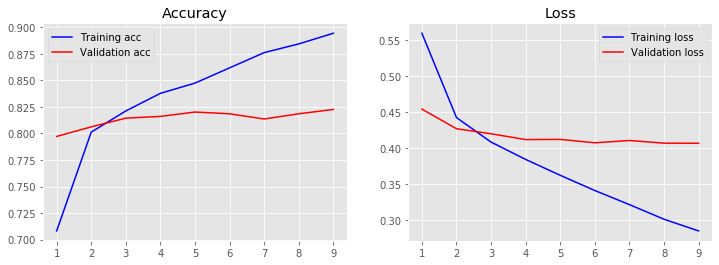

In [54]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()

plot_history(history)

In [55]:
#Set de validación
preds = model.predict(X_test)
preds = preds >= 0.5
preds

array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [56]:
f1score = f1_score(y_test, preds)
print(f'Counts model score: {f1score*100}%')

Counts model score: 75.81395348837209%


In [57]:
#Set de test
preds = model.predict(X_set_test)
preds = (preds >= 0.5).astype(int)
preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [58]:
preds.shape

(3263, 1)

In [59]:
tweets_test['target'] = preds
submission = tweets_test.loc[:,['id','target']]
submission.to_csv(path_or_buf='submissioncnn.csv',header=True,index=False)

In [ ]:
#Promedio
preds_xgb = pd.read_csv('submissionxgb.csv')['target']
preds_tfidf = pd.read_csv('submission.csv')['target']

In [ ]:
avg = (tweets_test['target'] + preds_tfidf + preds_xgb)/3
avg = (avg > 0.5).astype(int)

In [ ]:
tweets_test['target'] = avg
submission = tweets_test.loc[:,['id','target']]
submission.to_csv(path_or_buf='submissionavgcnntfidfxgb.csv',header=True,index=False)